importing libraries

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

loading train set

In [95]:
train = pd.read_csv("train.csv")
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,408561,8,11,4,10,8,5,6,7,2,...,2,4,6,8,7,6,8,4,8,0.630
1,70143,9,5,3,8,4,3,4,5,5,...,2,4,4,4,4,6,4,6,3,0.515
2,708782,4,6,10,3,5,2,4,2,6,...,4,8,5,4,3,3,2,5,1,0.440
3,572694,5,9,6,8,5,5,2,0,6,...,5,7,8,1,9,4,4,6,6,0.530
4,774181,8,2,3,2,7,7,3,7,5,...,2,2,9,6,8,0,4,8,6,0.530


check are all location ids are unique

In [96]:
duplicates = train[train.duplicated(subset=['id'])]
print(duplicates)

Empty DataFrame
Columns: [id, MonsoonIntensity, TopographyDrainage, RiverManagement, Deforestation, Urbanization, ClimateChange, DamsQuality, Siltation, AgriculturalPractices, Encroachments, IneffectiveDisasterPreparedness, DrainageSystems, CoastalVulnerability, Landslides, Watersheds, DeterioratingInfrastructure, PopulationScore, WetlandLoss, InadequatePlanning, PoliticalFactors, FloodProbability]
Index: []

[0 rows x 22 columns]


as the first column ('id') is categorical, and also it's unique in each row, it can be dropped because it cannot predict the probability

In [97]:
train = train.drop(columns=['id'])

now define a function to fill the missing value by knn imputer algorithm

In [98]:
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))

def knn_imputer_filling(input_data, k = 5):
    missing_data = [input_data.iloc[i] for i in range(len(input_data)) if input_data.iloc[i].isnull().values.any()]
    complete_data = input_data.dropna()
    for i in range(len(missing_data)):
        distances = []
        for j in range(len(complete_data)):
                dist = euclidean_distance(input_data.iloc[i].values, complete_data.iloc[j].values)
                distances.append((dist, j))
        distances.sort()
        nearest_neighbors = distances[:k]
        for col in input_data.columns:
            if np.isnan(input_data.iloc[i][col]):
                knn_sum = 0
                for dist, idx in nearest_neighbors:
                    knn_sum += complete_data.iloc[idx][col]
                missing_data.at[i, col] = knn_sum / len(nearest_neighbors)
    return complete_data.append(missing_data)

the imputer algorithm takes much time so we define a simple filling function that fill with means

In [99]:
def simple_filling(input_data):
    for col in input_data.columns:
        mean_value = input_data[col].mean()
        input_data[col].fillna(mean_value, inplace=True)
    return input_data

fill the missing if found

feature extraction part 1: creating correlation heatmap

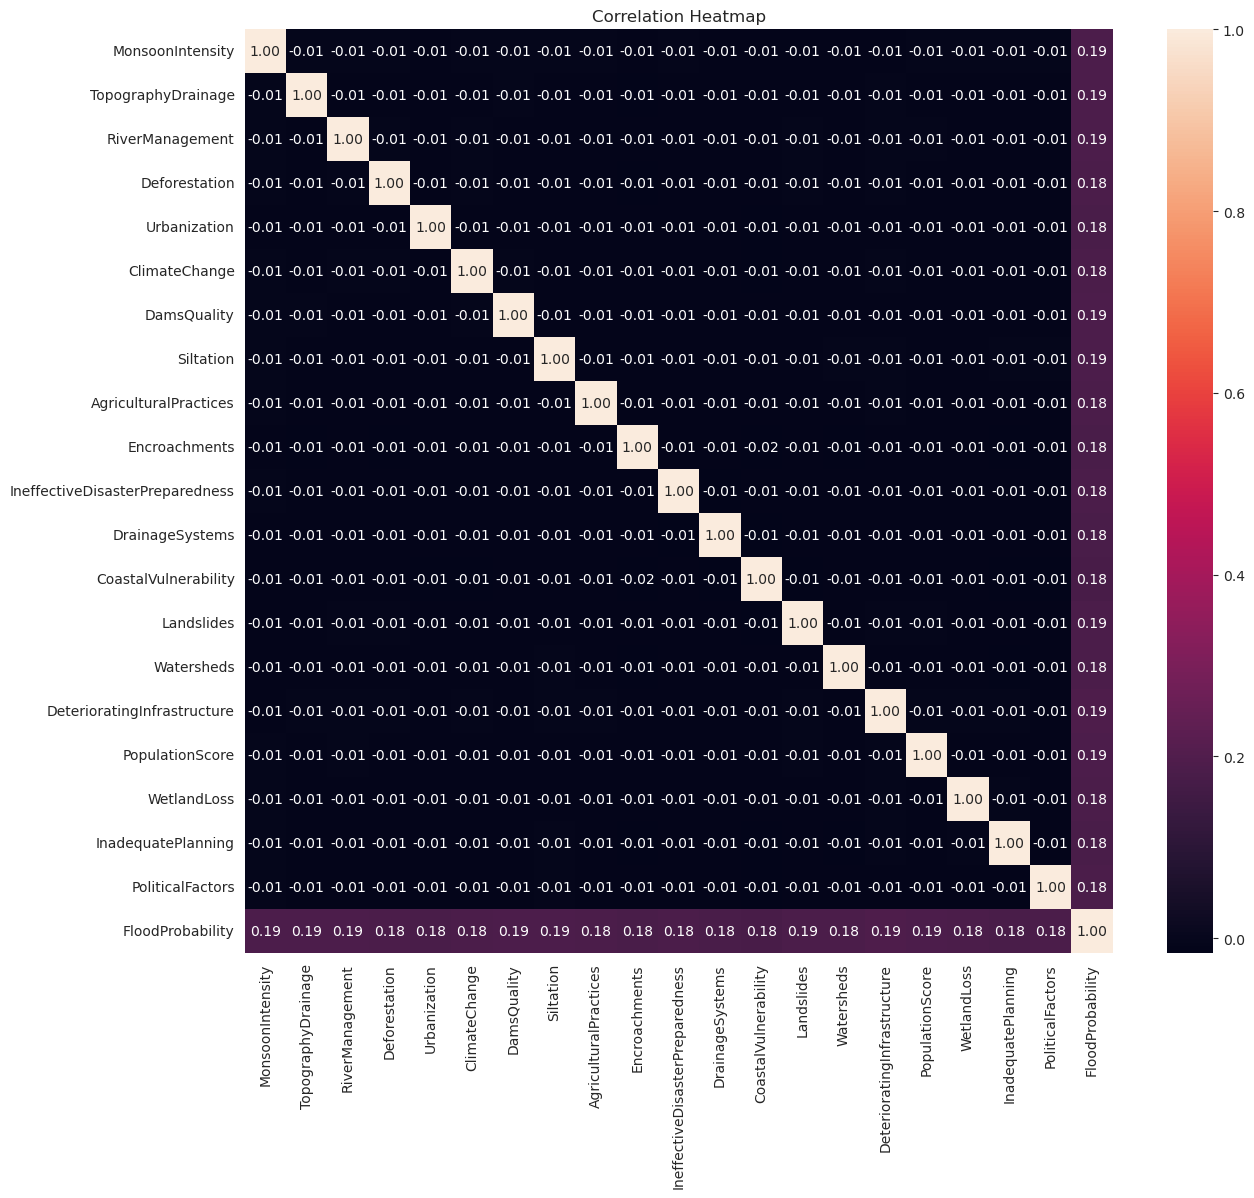

In [100]:
correlation_matrix = train.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

as we saw, there is no correlation between values so we should extract features by multiplying in 'feature.ipynb' notebook

as the 'DeterioratingInfrastructure' times the other column was made a better correlation, we multiply all column to it and insert a 

In [101]:
def add_new_features(input_data, effective_column="DeterioratingInfrastructure"):
    new_data = input_data.copy()
    for col in input_data.columns:
        if col != effective_column and col != "FloodProbability":
            new_data[effective_column + '-' + col] = input_data[col] * input_data[effective_column]
    new_data = new_data.drop(columns=[effective_column])
    return new_data

2 scaler function, both used for scaling datasets

In [102]:
def z_score_scaler(df):
    mean = df.mean()
    std = df.std()
    scaled_df = (df - mean) / std
    return scaled_df, mean, std

def min_max_scaler(df):
    min_val = df.min()
    max_val = df.max()
    scaled_df = (df - min_val) / (max_val - min_val) 
    return scaled_df, min_val, max_val

first fill data if there is NaN value, then create 4 dataset based on scaling and 

In [103]:
def create_datasets(input_data):
    if input_data.isnull().values.any():
        input_data = simple_filling(input_data)
        # train = knn_imputer_filling(train, 10)
    train_feature_plus = add_new_features(input_data)
    tfp_z, tpf_z_mean, tpf_z_std = z_score_scaler(train_feature_plus)
    tfp_m, tpf_m_min, tpf_m_max = min_max_scaler(train_feature_plus)
    train_z, train_z_mean, train_z_std = z_score_scaler(input_data)
    train_m, train_m_min, train_m_max = min_max_scaler(input_data)
    return [tfp_z, tfp_m, train_z, train_m], [[tpf_z_mean, tpf_z_std], [tpf_m_min, tpf_m_max], [train_z_mean, train_z_std], [train_m_min, train_m_max]]

defining datasets list a scalers list that contain parameters of scaling 

In [104]:
datasets, scalers = create_datasets(train)

dropping 'id' column as it's random, unique and categorical and severance independent variables from dependent

In [105]:
xs = []
ys = []
for data in datasets:
    y = data['FloodProbability'].to_numpy()
    ys.append(y)
    x = data.drop(['FloodProbability'], axis=1).to_numpy()
    xs.append(x)
xs[0]

array([[ 1.49693007,  2.90124353, -0.46151393, ...,  2.11684195,
         0.24692997,  2.11270462],
       [ 1.98320357,  0.03520959, -0.94413678, ..., -0.5583355 ,
        -0.02047435, -0.8197577 ],
       [-0.44816393,  0.51288191,  2.4342232 , ..., -1.22712987,
        -0.62213407, -1.41957954],
       ...,
       [ 0.03810957, -0.44246274, -1.90938249, ...,  0.37797661,
         0.71488754,  0.71312033],
       [ 0.52438307,  2.4235712 , -0.46151393, ..., -0.29081776,
         0.04637673,  0.04665162],
       [ 0.03810957,  0.99055423, -1.42675964, ..., -0.29081776,
        -0.28787867,  0.71312033]])

getting dataset rows and columns

In [106]:
xs[1].shape

(838860, 38)

defining start point (it could be random!)

In [107]:
weights = [np.full(xs[i].shape[1], 0.0, dtype=np.float64) for i in range(len(datasets))]
biases = [0.0 for i in range(len(datasets))]
weights

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])]

linear regression function explained by comments in code

In [108]:
def linear_regression(epochs_number, initial_learning_rate, intercept, slope, x_train, y_train, momentum=0,
                      patience=np.inf, regularization_param=0, lr_decrease=1, iteration_sample=10000):
    rows, columns = x_train.shape

    # initialize momentum
    slope_velocity = np.zeros(columns)
    intercept_velocity = 0

    # early stopping param
    best_mse = float('inf')
    patience_counter = 0
    best_slope = np.zeros(columns)
    best_intercept = 0
    
    # learning rate
    learning_rate = initial_learning_rate
    total_epoch = epochs_number
    learning_rate_serie = []
    
    # per epoch 
    mse_per_epoch = []
    mae_per_epoch = []
    # per iteration (flushed per number of samples)
    mse_per_iteration = []
    mae_per_iteration = []
    # per sample
    sampled_mse = []
    sampled_mae = []
    
    iteration_counter = 0
    
    for epoch in range(epochs_number):
        total_mse = 0
        total_mae = 0
        
        # shuffle data in each epoch
        permutation = np.random.permutation(rows)
        x_train = x_train[permutation]
        y_train = y_train[permutation]
        
        for i in range(rows):
            selected_row = x_train[i, :]
            prediction = np.dot(selected_row, slope) + intercept
            real = y_train[i]

            # gradients with L2 regularization for the slope (not for intercept)
            slope_gradient = selected_row * (prediction - real) * 2 + regularization_param * slope
            intercept_gradient = (prediction - real) * 2

            # calculate momentum
            slope_velocity = momentum * slope_velocity + learning_rate * slope_gradient
            intercept_velocity = momentum * intercept_velocity + learning_rate * intercept_gradient

            # update parameters
            slope -= slope_velocity
            intercept -= intercept_velocity

            # errors for mse and mae
            iteration_mse = (prediction - real) ** 2
            iteration_mae = abs(prediction - real)
            total_mse += iteration_mse
            total_mae += iteration_mae

            # per iteration mse and mae
            mse_per_iteration.append(iteration_mse)
            mae_per_iteration.append(iteration_mae)

            # sampling mse and mae
            if (iteration_counter + 1) % iteration_sample == 0:
                current_sample_mse = np.mean(mse_per_iteration)
                sampled_mse.append(current_sample_mse)
                sampled_mae.append(np.mean(mae_per_iteration))
                mse_per_iteration = []
                mae_per_iteration = []
                
                # learning rate decrease
                learning_rate *= lr_decrease
                learning_rate_serie.append(learning_rate)
                
                # early stopping
                if current_sample_mse < best_mse:
                    best_mse = current_sample_mse
                    patience_counter = 0
                    best_slope = slope
                    best_intercept = intercept
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at iteration {iteration_counter + 1} with MSE: {current_sample_mse}")
                        total_epoch = epoch + 1
                        break
                        
            iteration_counter += 1
        
        # average error for the epoch
        mse_val = total_mse / rows
        mae_val = total_mae / rows
        mse_per_epoch.append(mse_val)
        mae_per_epoch.append(mae_val)

        

        # break loop if early stopped
        if patience_counter >= patience:
            break
    
    # plotting
    
    # combine subplot
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle("Training Metrics Over Epochs and Iterations")

    # mse per epoch
    axs[0, 0].plot(range(1, total_epoch + 1), mse_per_epoch, label='MSE per Epoch', color='blue')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].set_title('MSE per Epoch')
    axs[0, 0].legend()

    # mae per epoch
    axs[0, 1].plot(range(1, total_epoch + 1), mae_per_epoch, label='MAE per Epoch', color='orange')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].set_title('MAE per Epoch')
    axs[0, 1].legend()

    # mse per sample iter
    axs[1, 0].plot(range(len(sampled_mse)), sampled_mse, label=f'MSE (Sampled every {iteration_sample} Iterations)', color='purple')
    axs[1, 0].set_xlabel(f'Sample Interval ({iteration_sample} Iterations)')
    axs[1, 0].set_ylabel('Sampled MSE')
    axs[1, 0].set_title(f'Sampled MSE per {iteration_sample} Iterations')
    axs[1, 0].legend()

    # mae per sample iter
    axs[1, 1].plot(range(len(sampled_mae)), sampled_mae, label=f'MAE (Sampled every {iteration_sample} Iterations)', color='green')
    axs[1, 1].set_xlabel(f'Sample Interval ({iteration_sample} Iterations)')
    axs[1, 1].set_ylabel('Sampled MAE')
    axs[1, 1].set_title(f'Sampled MAE per {iteration_sample} Iterations')
    axs[1, 1].legend()

    # learning rate per iter
    axs[2, 0].plot(range(len(learning_rate_serie)), learning_rate_serie, label='Learning Rate per Epoch', color='red')
    axs[1, 0].set_xlabel(f'Sample Interval ({iteration_sample} Iterations)')
    axs[2, 0].set_ylabel('Sampled Learning Rate')
    axs[2, 0].set_title(f'Sampled Learning Rate per {iteration_sample} Iterations')
    axs[2, 0].legend()

    # remove empty subplot
    fig.delaxes(axs[2, 1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return best_slope, best_intercept


training model in the base mode

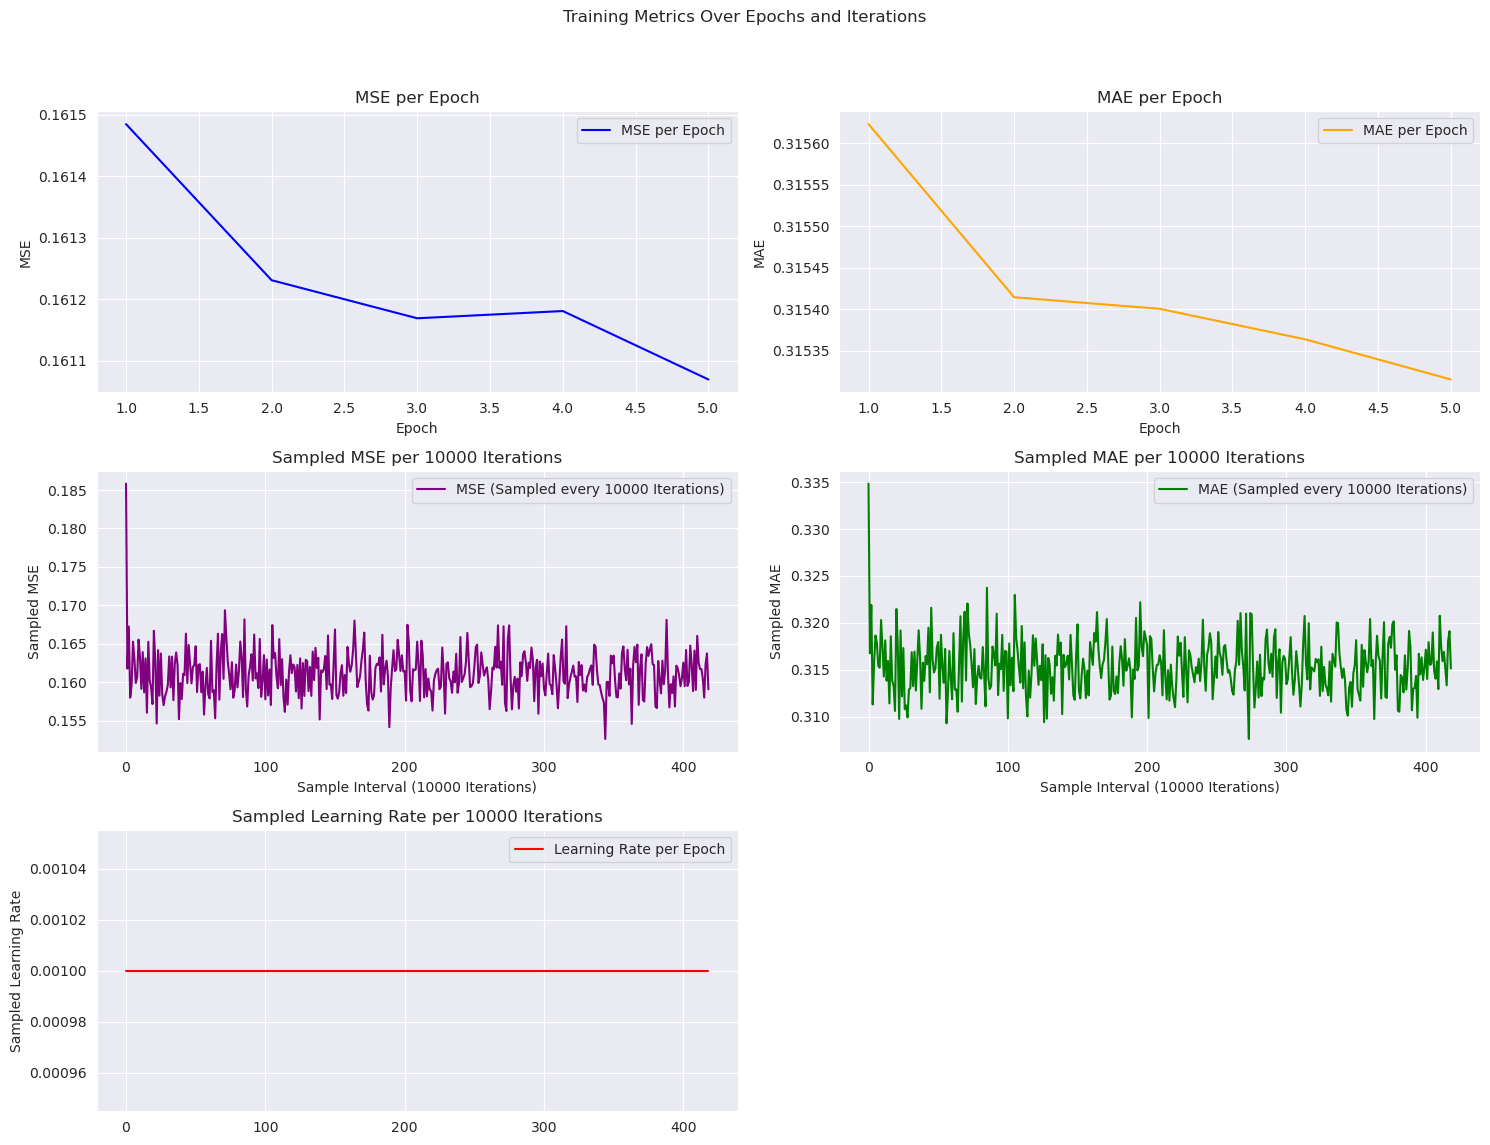

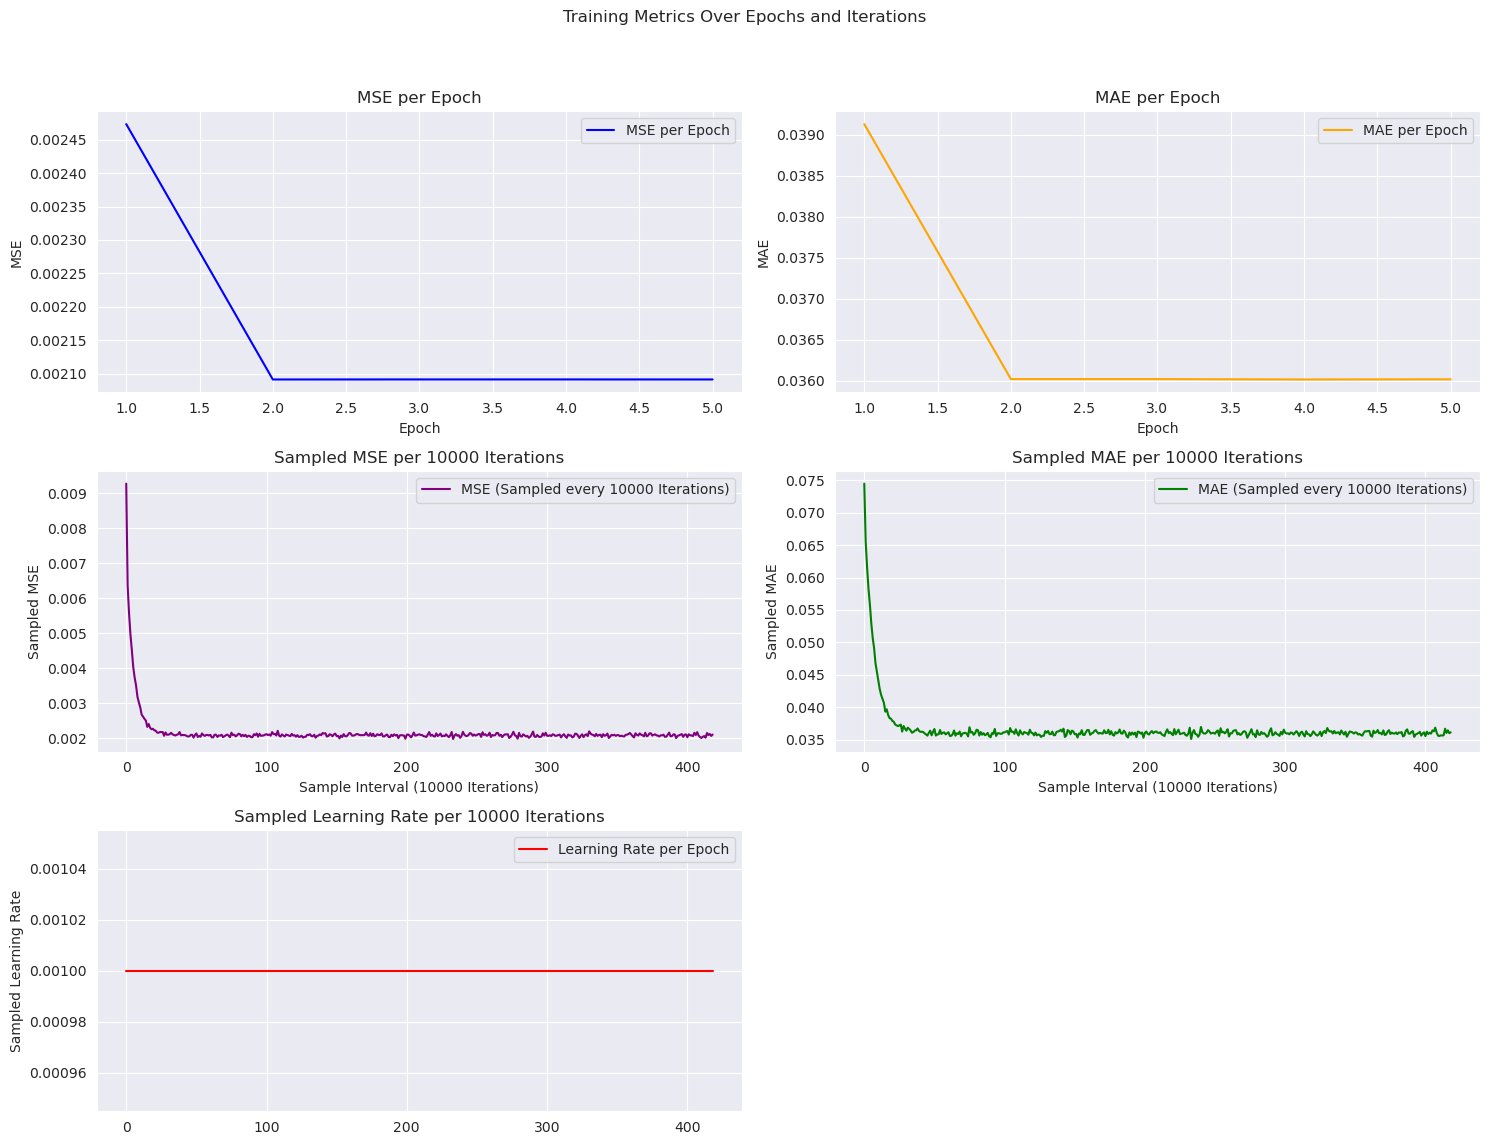

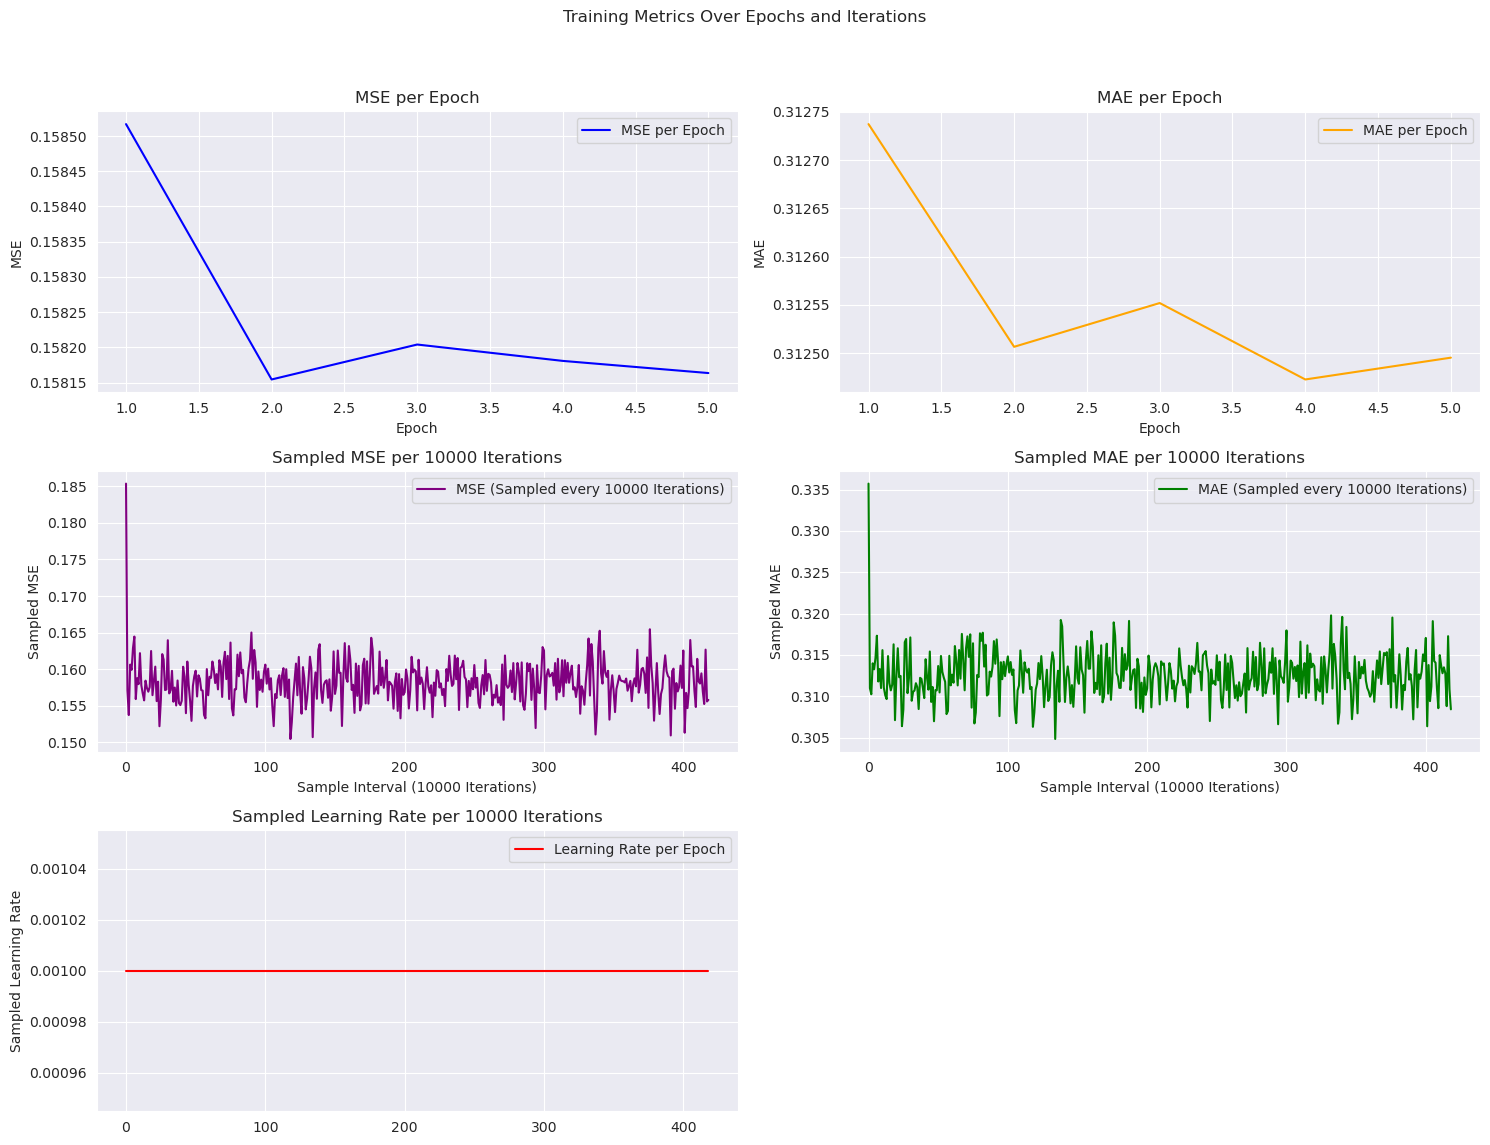

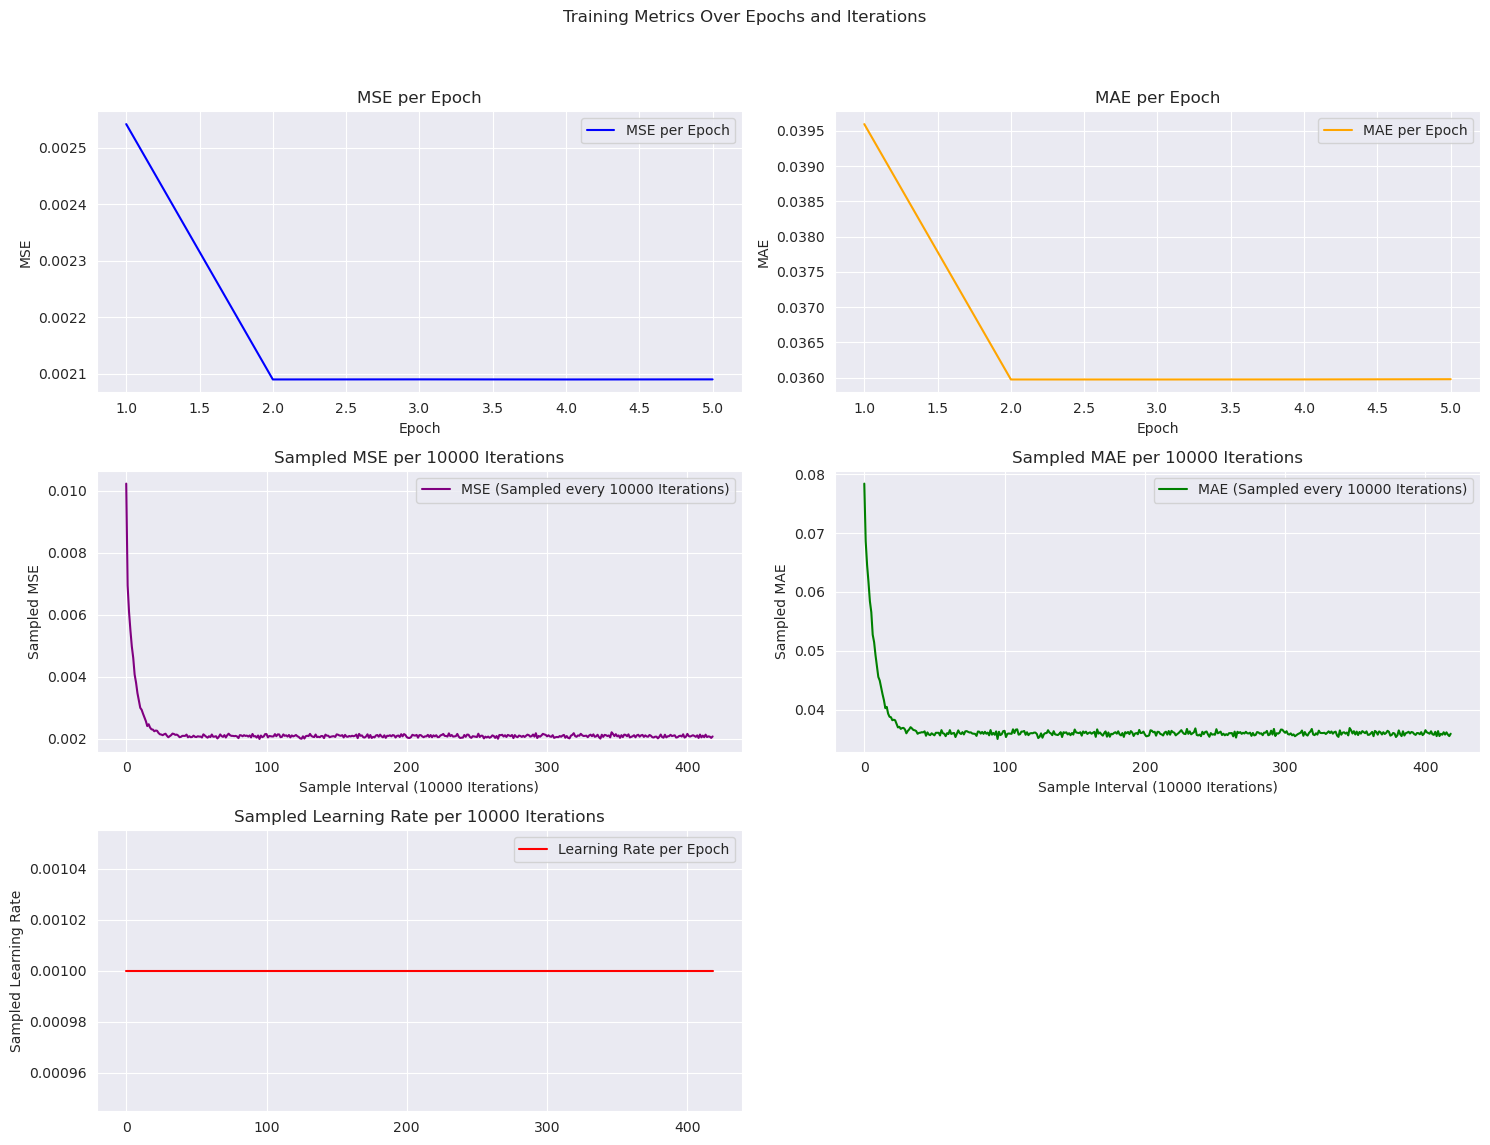

In [109]:
epochs = 5
result_w = weights.copy()
result_b = biases.copy()
for i in range(len(datasets)):
    result_w[i], result_b[i] = linear_regression(epochs, 0.001, biases[i], weights[i], xs[i], ys[i])

checking slope values

In [110]:
result_w

[array([ 2.31701744e-01,  2.06497543e-01,  1.98843295e-01,  2.09979146e-01,
         2.21161318e-01,  2.14024238e-01,  2.25448916e-01,  2.43181899e-01,
         2.20021849e-01,  2.12198177e-01,  2.14593307e-01,  2.30551041e-01,
         2.20304921e-01,  2.04822253e-01,  2.29041188e-01,  2.34394273e-01,
         2.02522240e-01,  2.03660129e-01,  2.54449706e-01,  3.39088839e-02,
        -1.12727980e-02,  2.45271061e-02,  2.48137312e-02,  2.62155819e-02,
        -1.57640758e-02,  4.28890401e-03,  3.65865983e-02,  3.52860099e-02,
         2.13798159e-02,  6.36685025e-04,  1.14326189e-02,  1.56472991e-02,
         7.22441527e-03,  2.73217884e-02,  2.29898151e-02,  3.22871775e-02,
         1.57565562e-02, -1.22282408e-04]),
 array([0.18878927, 0.21922994, 0.19549034, 0.20701783, 0.20649968,
        0.20600315, 0.19283374, 0.19066336, 0.19433926, 0.22071077,
        0.19303925, 0.20772737, 0.20896615, 0.19340875, 0.1956273 ,
        0.22170053, 0.20300893, 0.19499768, 0.19144027, 0.02500169,


predict function calculates scores

In [111]:
def predict(x_test, y_test, slope, intercept):
    y_predicted = np.dot(x_test, slope) + intercept
    mse = np.mean((y_test - y_predicted) ** 2)
    mae = np.mean(np.abs(y_test - y_predicted))
    r2 = 1 - (np.sum((y_test - y_predicted) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")
    return y_predicted

calculate scores for train itself

In [112]:
for i in range(len(datasets)):
    predict(xs[i], ys[i], result_w[i], result_b[i])


Mean Absolute Error: 0.31507941284243074
Mean Squared Error: 0.1623265426408771
R2 Score: 0.8376732638500413
Mean Absolute Error: 0.03568546670577593
Mean Squared Error: 0.002092936926478289
R2 Score: 0.8444770494878399
Mean Absolute Error: 0.31196980207416125
Mean Squared Error: 0.157758678705043
R2 Score: 0.842241133231215
Mean Absolute Error: 0.03601188371181068
Mean Squared Error: 0.002084827486310387
R2 Score: 0.8450796496168538


loading test file

In [113]:
test = pd.read_csv("test.csv")
test = test.drop(columns=['id'])
test.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,4,3,5,6,3,2,10,3,3,12,...,5,6,4,5,2,3,5,5,8,0.505
1,7,3,5,1,3,7,3,2,3,8,...,8,4,4,6,7,2,6,6,4,0.470
2,4,3,3,5,4,5,4,4,3,5,...,4,8,5,6,5,8,7,7,4,0.490
3,5,7,6,5,3,6,6,4,9,6,...,5,4,5,8,12,7,5,4,4,0.610
4,10,2,4,3,5,3,3,7,7,5,...,4,3,6,6,6,6,7,6,6,0.540


scaler function for known scale values

In [114]:
def z_score_scaler_test(input_data, mean, std):
    scaled_df = (input_data - mean) / std
    return scaled_df

def min_max_scaler_test(input_data, min_val, max_val):
    scaled_df = (input_data - min_val) / (max_val - min_val) 
    return scaled_df

creating test datasets as train

In [115]:

def create_test_datasets(input_data, scaler):
    if input_data.isnull().values.any():
        input_data = simple_filling(input_data)
        # train = knn_imputer_filling(train, 10)
    train_feature_plus = add_new_features(input_data)
    tfp_z = z_score_scaler_test(train_feature_plus, scaler[0][0], scaler[0][1])
    tfp_m = min_max_scaler_test(train_feature_plus, scaler[1][0], scaler[1][1])
    train_z = z_score_scaler_test(input_data, scaler[2][0], scaler[2][1])
    train_m = min_max_scaler_test(input_data,scaler[3][0], scaler[3][1])
    return [tfp_z, tfp_m, train_z, train_m]

severance dependent and independent variables

In [116]:
test_datasets = create_test_datasets(test, scalers)
print(test_datasets)
xs_test = []
ys_test = []
for data in test_datasets:
    y = data['FloodProbability'].to_numpy()
    ys_test.append(y)
    x = data.drop(['FloodProbability'], axis=1).to_numpy()
    xs_test.append(x)

[        MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0              -0.448164           -0.920135         0.021109       0.514933   
1               1.010657           -0.920135         0.021109      -1.920882   
2              -0.448164           -0.920135        -0.944137       0.027770   
3               0.038110            0.990554         0.503732       0.027770   
4               2.469477           -1.397807        -0.461514      -0.946556   
...                  ...                 ...              ...            ...   
209710         -0.448164            0.512882        -0.461514      -0.459393   
209711          0.524383            0.035210        -1.909382       0.514933   
209712          1.010657            0.512882        -0.461514       0.514933   
209713          1.010657           -0.442463         0.021109       0.027770   
209714         -0.448164            0.035210         1.468977      -0.459393   

        Urbanization  ClimateChange  D

calculating test scores on the trained model

In [117]:
for i in range(len(datasets)):
    predict(xs_test[i], ys_test[i], result_w[i], result_b[i])

Mean Absolute Error: 0.31541386419203477
Mean Squared Error: 0.16264066000908373
R2 Score: 0.8369815595044554
Mean Absolute Error: 0.03573379083560483
Mean Squared Error: 0.0020991116853781642
R2 Score: 0.843656085642022
Mean Absolute Error: 0.3123328578985867
Mean Squared Error: 0.15816693495397274
R2 Score: 0.8414656760940543
Mean Absolute Error: 0.036048416960244904
Mean Squared Error: 0.002089310904486879
R2 Score: 0.8443860574958219


creating a new model and train it by extra features like early stopping, momentum, and learning rate decrease and calculating the score

Early stopping at iteration 1180000 with MSE: 0.15220443495218214


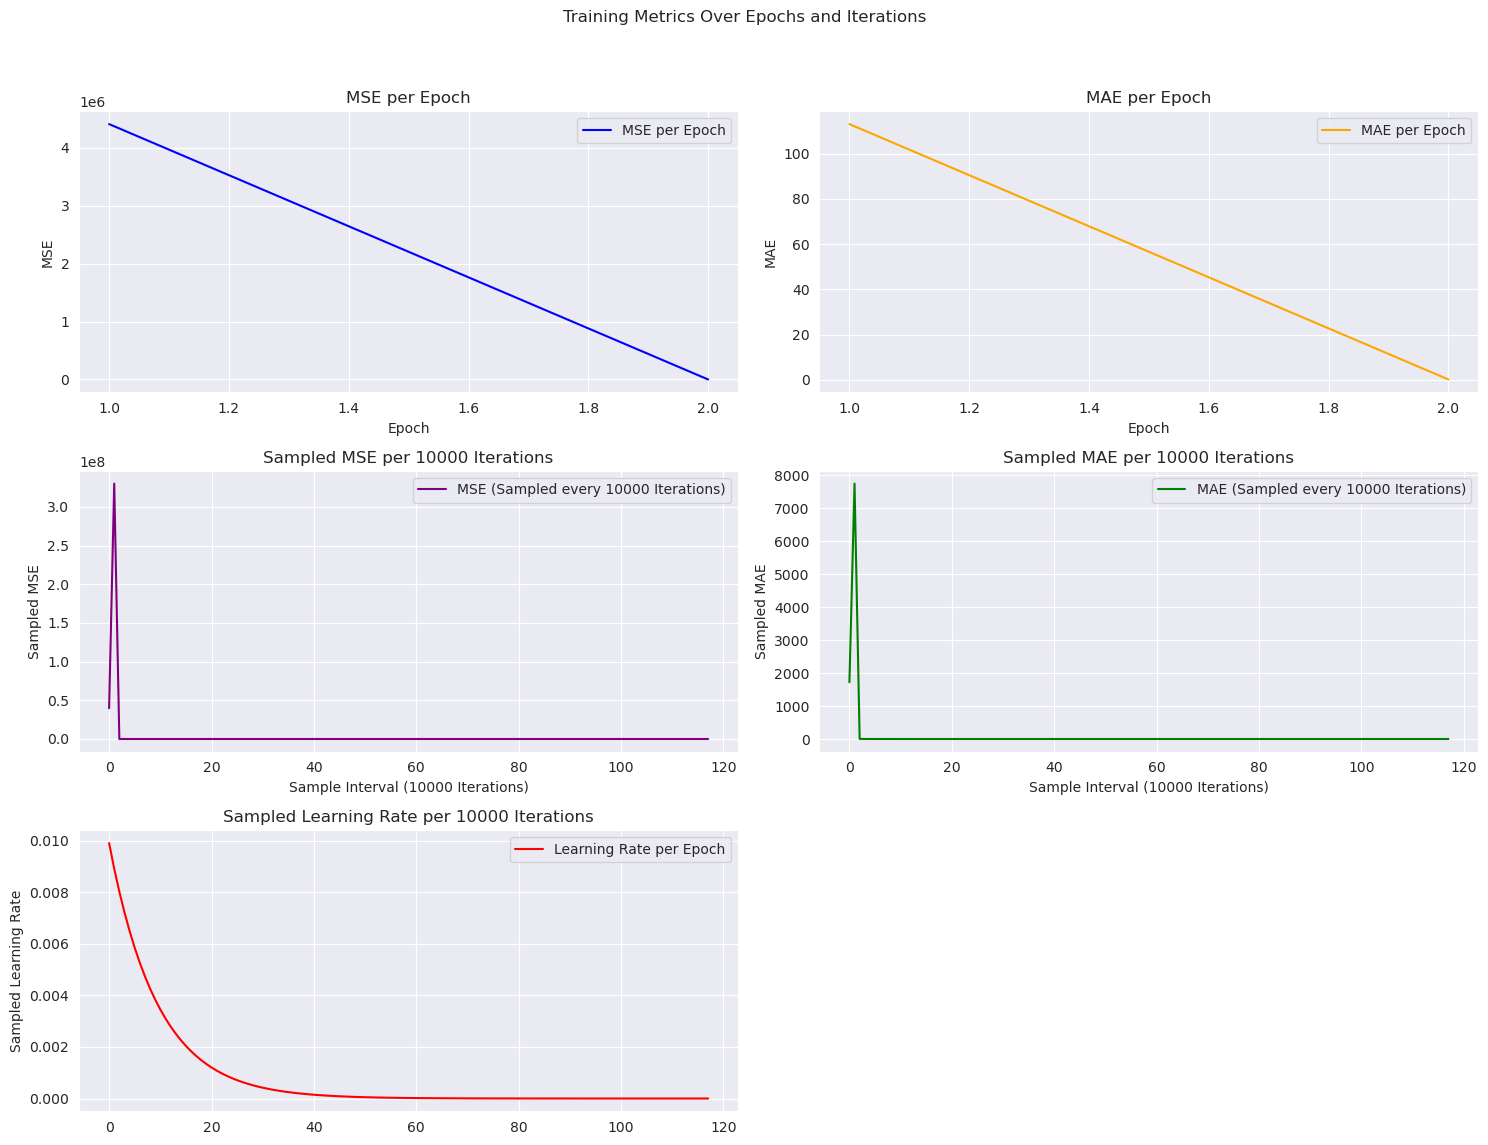

Early stopping at iteration 560000 with MSE: 0.0020854172020579047


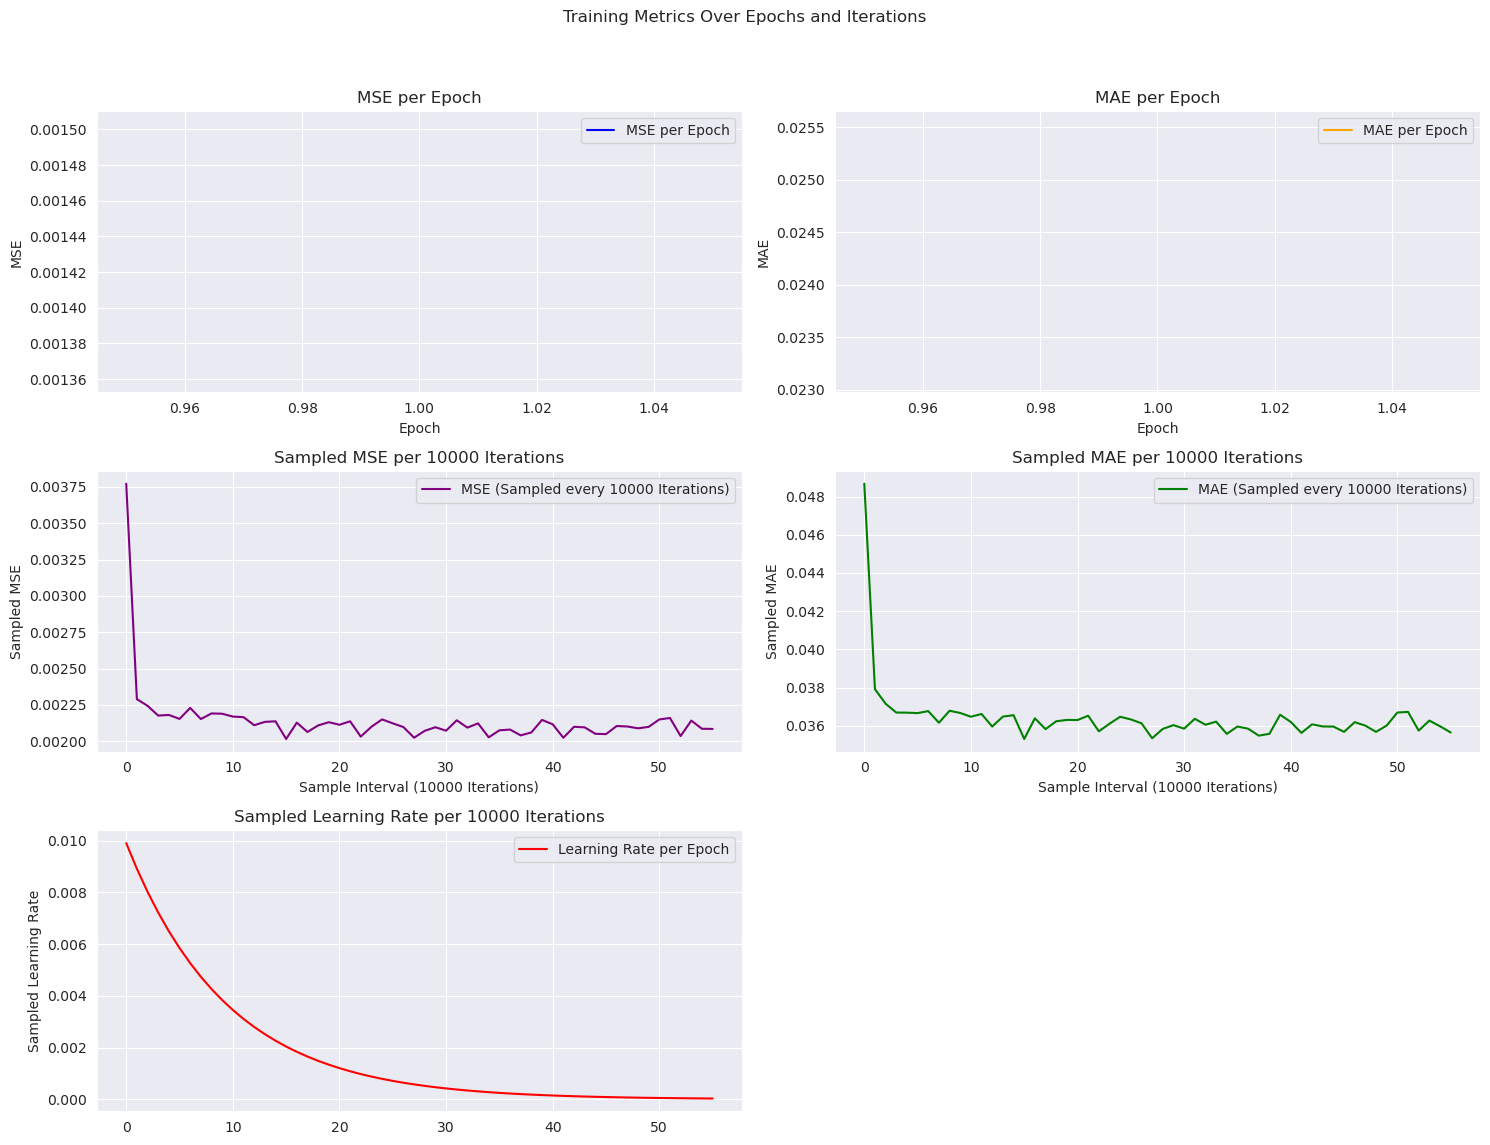

Early stopping at iteration 1160000 with MSE: 0.1510529396797828


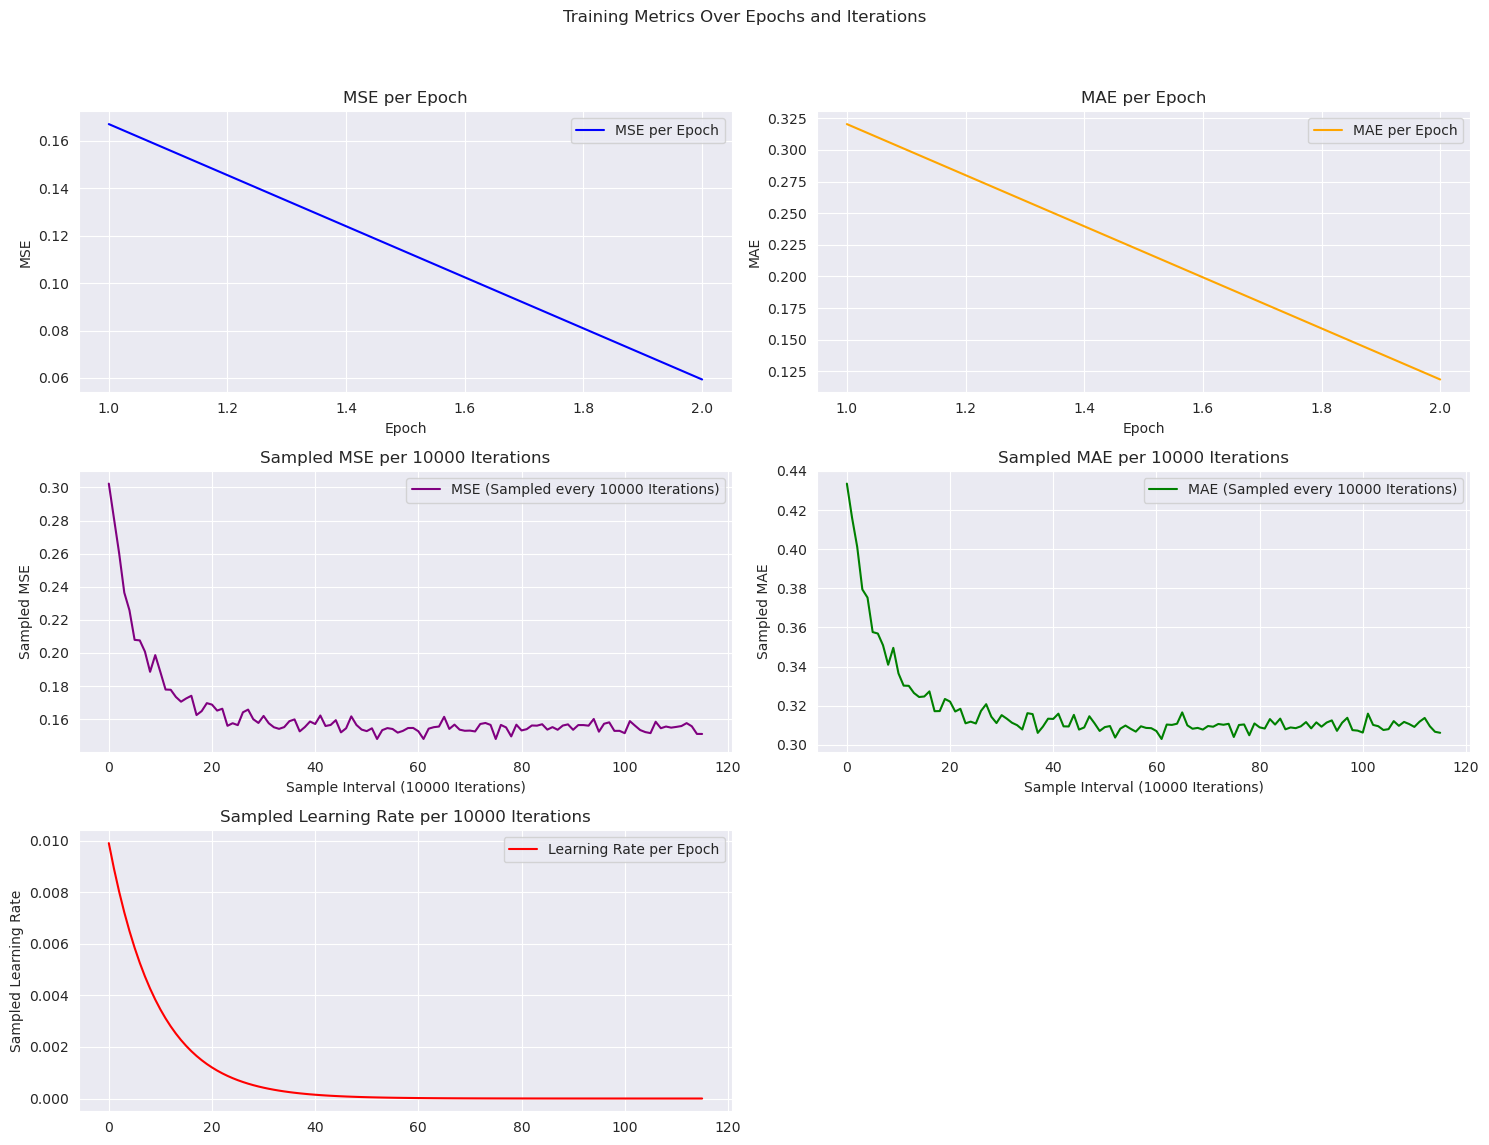

Early stopping at iteration 1020000 with MSE: 0.002082559212132916


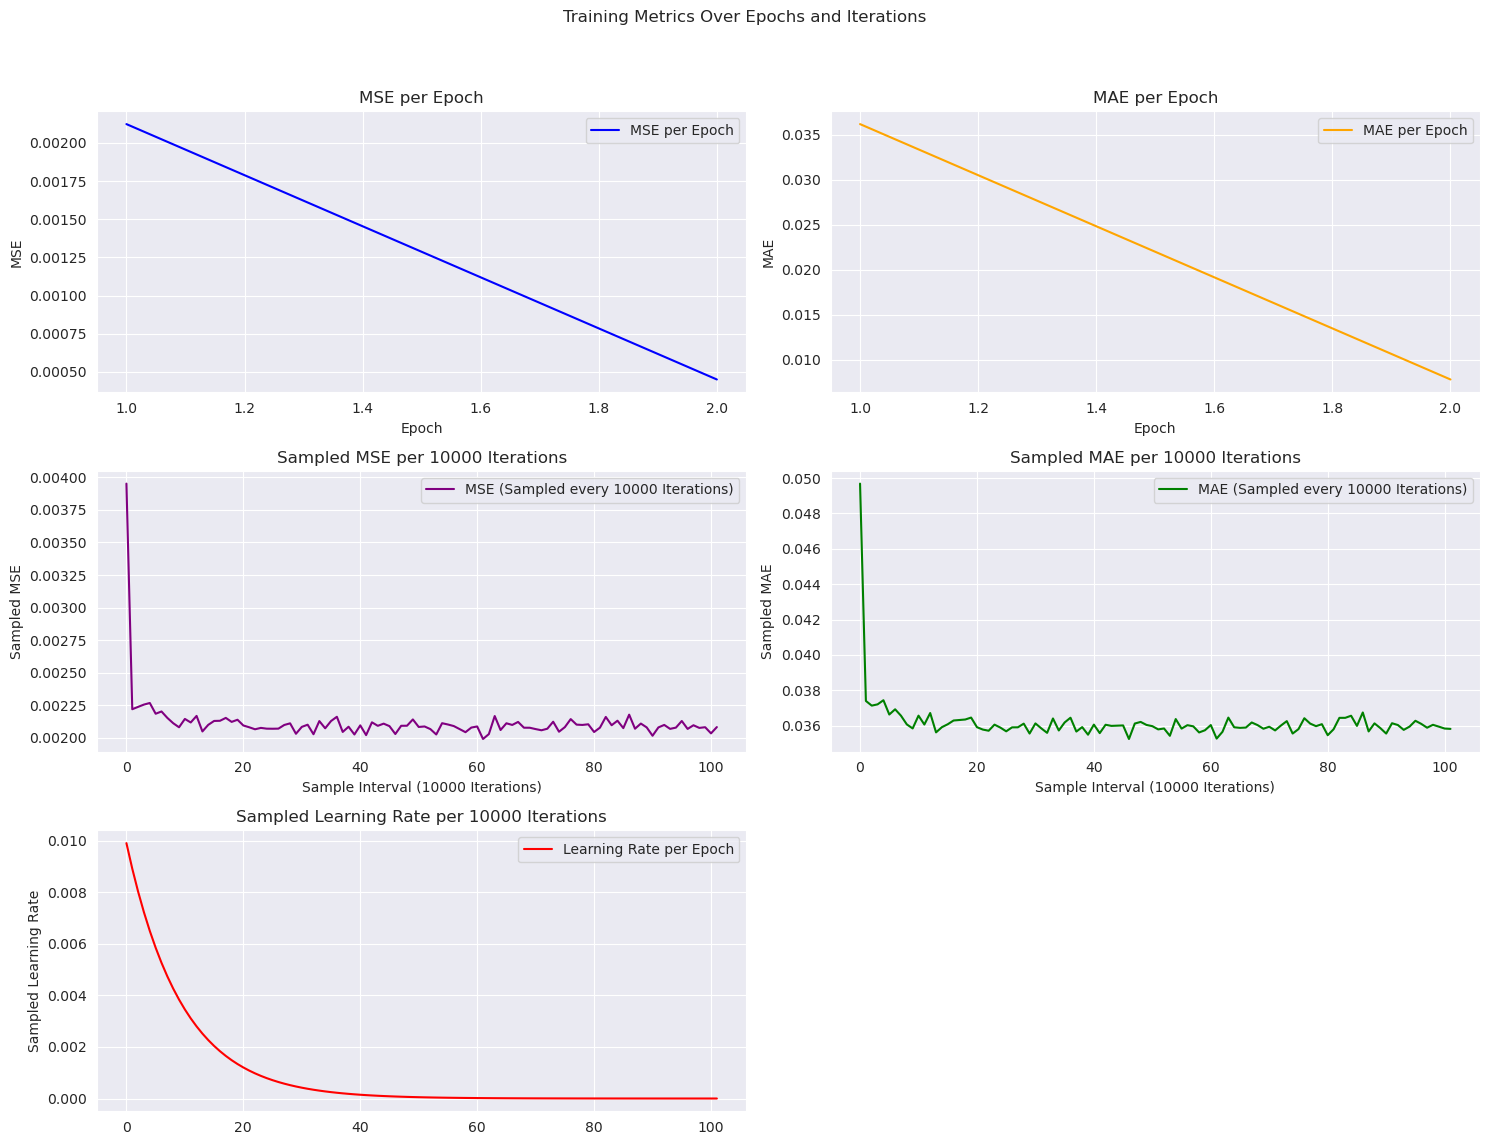

Mean Absolute Error: 0.3103204614283436
Mean Squared Error: 0.15531659704955475
R2 Score: 0.8443226347416497
Mean Absolute Error: 0.03590151380468769
Mean Squared Error: 0.0020908554102839405
R2 Score: 0.8442710211765334
Mean Absolute Error: 0.31020869129867285
Mean Squared Error: 0.1552026650245299
R2 Score: 0.8444368314071146
Mean Absolute Error: 0.035901684589193086
Mean Squared Error: 0.002088607436321697
R2 Score: 0.8444384525004979


In [118]:
weights2 = [np.full(xs[i].shape[1], 0.0, dtype=np.float64) for i in range(len(datasets))]
biases2 = [0.0 for i in range(len(datasets))]

epochs = 30
result_w2 = weights2.copy()
result_b2 = biases2.copy()
for i in range(len(datasets)):
    result_w2[i], result_b2[i]= linear_regression(epochs_number=epochs, initial_learning_rate=0.011, intercept=biases2[i], slope=weights2[i], x_train=xs[i], y_train=ys[i], momentum=0.5, patience=40, regularization_param=0.0, lr_decrease=.9, iteration_sample=10000)
    

predicted_test2 = []
for i in range(len(datasets)):
    predicted_test2.append(predict(xs_test[i], ys_test[i], result_w2[i], result_b2[i]))